In [1]:
import numpy as np
import SimpleITK as sitk
from nd2reader import ND2Reader
import h5py
import matplotlib.pyplot as plt
%matplotlib inline 

/home/jlove/software/anaconda/envs/exm-toolbox/lib/python3.7/site-packages/pims/image_reader.py:26: RuntimeWarning: PIMS image_reader.py could not find scikit-image. Falling back to matplotlib's imread(), which uses floats instead of integers. This may break your scripts. 
(To ignore this warning, include the line "warnings.simplefilter("ignore", RuntimeWarning)" in your script.)
  warnings.warn(RuntimeWarning(ski_preferred))


In [2]:
!python -V

# 3.7 and below works with ND2Reader, need to set to 3.7 then re-make the Elastix

Python 3.9.7


In [3]:
# About: Round 1 to Round 4 are images of 12 RNAs using HCR-FISH, 
# Round 5 to Round 7 are images of proteins using antibody staining. 
# We want to align rounds of images using the 405 channel (index 0), and register to Round 1.
# We will perform segmentation later. 

In [4]:
#!pip install nd2
#from alignment_modules import nd2ToVol

In [19]:
cropped_h5 = '/home/jlove/alignment/ExM-Toolbox/notebook/chai/croped.h5'
f = h5py.File(cropped_h5, "r+")

In [6]:
f.keys()

<KeysViewHDF5 ['cropped_b6', 'mov', 'temp']>

In [13]:
f['cropped_b6']['cropped_b6']

<HDF5 dataset "cropped_b6": shape (56, 500, 2048), type "<u2">

In [14]:
outputs = []

f_vol_fix = f['temp']['1']

for i in range(1):
    f_vol_move = f['cropped_b6']['cropped_b6']
    f_vol_out = '/home/jlove/alignment/ExM-Toolbox/notebook/chai/cropped_warped_b6.h5'
    
    m_transform_type = ['affine'] 
    m_channel_name = '405' # okay to be partial name
    m_resolution = [1.625,1.625, 4] # um: xyz. the image volume is in zyx-order
    
    # main function to run
    elastixImageFilter = sitk.ElastixImageFilter()

    # 1. set transformation parameters
    if len(m_transform_type) == 1:
        param_map = sitk.GetDefaultParameterMap(m_transform_type[0])
        param_map['NumberOfSamplesForExactGradient'] = ['100000']
        param_map['MaximumNumberOfIterations'] = ['10000']
        param_map['MaximumNumberOfSamplingAttempts'] = ['15']
        param_map['FinalBSplineInterpolationOrder'] = ['1']
        elastixImageFilter.SetParameterMap(param_map)
    else:
        parameterMapVector = sitk.VectorOfParameterMap()
        for trans in m_transform_type:
            parameterMapVector.append(sitk.GetDefaultParameterMap(trans))
        elastixImageFilter.SetParameterMap(parameterMapVector)

    # 2. load volume
    img_np = np.asarray(f_vol_fix)
    print('vol-fix shape:', img_np.shape)
    img = sitk.GetImageFromArray(img_np)
    img.SetSpacing(m_resolution)
    elastixImageFilter.SetFixedImage(img)
    
    img_np = np.asarray(f_vol_move)
    print('vol-move shape:', img_np.shape)
    img = sitk.GetImageFromArray(img_np)
    img.SetSpacing(m_resolution)
    elastixImageFilter.SetMovingImage(img)

    # 3. compute transformation
    elastixImageFilter.Execute()

    # 4. save output
    # save transformation param
    param_map = elastixImageFilter.GetTransformParameterMap()[0]
    sitk.WriteParameterFile(param_map, f_vol_out[:f_vol_out.rfind('.')] + '.txt')

    # save warped channels
    channel_names = ['405']

    if len(channel_names) == 1:
        # directly save
        sitk.WriteImage(sitk.Cast(elastixImageFilter.GetResultImage(), sitk.sitkUInt16), f_vol_out)
    else:
        fid = h5py.File(f_vol_out, 'w')
        ds = fid.create_dataset('spacing', [3], compression="gzip", dtype=int)
        ds[:] = np.array(m_resolution).astype(int)
        # image type: float -> np.uint16
        img_out = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage()).astype(np.uint16)
        ds = fid.create_dataset([x for x in channel_names if m_channel_name in x][0], img_out.shape, compression="gzip", dtype=img_out.dtype)
        ds[:] = img_out

        # warp other channels
        transformixImageFilter = sitk.TransformixImageFilter()
        transformixImageFilter.SetTransformParameterMap(param_map)
        for channel_name in channel_names:
            if m_channel_name not in channel_name:
                img_np = nd2ToVol(f_vol_move, channel_name)
                print('vol 2:', channel_name, img_np.shape)
                img = sitk.GetImageFromArray(img_np)
                img.SetSpacing(m_resolution)
                transformixImageFilter.SetMovingImage(img)
                transformixImageFilter.Execute()
                img_out = sitk.GetArrayFromImage(transformixImageFilter.GetResultImage()).astype(np.uint16)
                ds = fid.create_dataset(channel_name, img_out.shape, compression="gzip", dtype=img_out.dtype)
                ds[:] = img_out
        fid.close()
        
    outputs.append(f_vol_out)

vol-fix shape: (76, 700, 2048)
vol-move shape: (56, 500, 2048)


In [20]:
f2 = h5py.File(outputs[0], 'r')

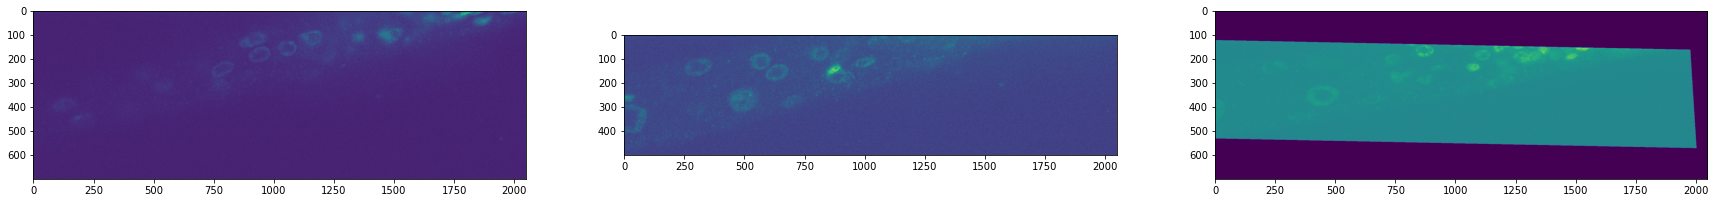

In [32]:
fig, ax = plt.subplots(1,3,figsize=(30,20))
ax[0].imshow(f['temp']['1'][0,])
ax[1].imshow(f['cropped_b6']['cropped_b6'][0,])
ax[2].imshow(f2['ITKImage']['0']['VoxelData'][0,])

In [ ]:
# Visualize results

# from alignment_modules import display_vol

# round_ = 2 
# assert round_ in [2, 3, 4, 5, 6, 7]

# f_vol_out = outputs[round_ - 2]
# viewer = napari.Viewer()
# channel_names = ND2Reader(f_vol_fix).metadata['channels']
# display_vol(f_vol_fix, f_vol_out, channel_names[0])